In [2]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

In [3]:
data_dir = "../data/iphone12pro/"

In [8]:
################### Load in data
# Start with the lens positions/diopters
with open(f'{data_dir}/lens_positions.pickle', 'rb') as handle:
    lens_positions = pickle.load(handle)

with open(f'{data_dir}/api_positions.pickle', 'rb') as handle:
    api_positions = pickle.load(handle)
    print("API positions:", api_positions)

lens_positions = np.array(lens_positions)
print("Lens positions in diopter (1/m):", lens_positions-lens_positions[8])

# Second, the patterns
with open(f'{data_dir}/train_patterns.pickle', 'rb') as handle:
    patterns = pickle.load(handle)
    patterns = [str(pat).split('-')[-1] for pat in patterns]
    print("Data Patterns:", patterns)

API positions: [0.    0.054 0.107 0.161 0.214 0.268 0.321 0.375 0.429 0.482 0.536 0.589
 0.643 0.696 0.75 ]
Lens positions in diopter (1/m): [ 0.42047325  0.38435285  0.3513518   0.31997388  0.29116812  0.2632587
  0.18844806  0.07993472  0.         -0.09155561 -0.15423161 -0.23537799
 -0.34252017 -0.42752253 -0.51051334]
Data Patterns: ['10', '100', '20', '50', '70']


In [4]:
# Second, the patterns
with open(f'{data_dir}/test_data/test_patterns.pickle', 'rb') as handle:
    test_patterns = pickle.load(handle)
    test_patterns = [str(pat).split('-')[-1] for pat in patterns]
    print("Test Data Patterns:", test_patterns)

Test Data Patterns: ['10', '100', '20', '50', '70']


In [5]:
# Third, our blurry and sharp data
blurry_np = np.load(f'{data_dir}/blurry.npy')
sharp_np  = np.load(f'{data_dir}/sharp.npy')
# sharp_np /= np.max(blurry_np)
# blurry_np /= np.max(blurry_np)

In [6]:
# Third, our blurry and sharp data
test_blurry_np = np.load(f'{data_dir}/test_data/test_blurry.npy')
test_sharp_np  = np.load(f'{data_dir}/test_data/test_sharp.npy')
# test_sharp_np /= np.max(test_blurry_np)
# test_blurry_np /= np.max(test_blurry_np)

In [7]:
test_blurry_np.shape, test_sharp_np.shape

((5, 15, 3024, 4032), (5, 15, 3024, 4032, 4))

In [8]:
def downsample_blurry(array, target_height, target_width):
    """
    Downsample a 4D array using OpenCV's resize function.
    
    Parameters:
    - array: The input 4D array.
    - target_height: The target height for the downsampled slices.
    - target_width: The target width for the downsampled slices.
    
    Returns:
    - A new 4D array with the downsampled slices.
    """
    downsampled = np.zeros((array.shape[0], array.shape[1], target_height, target_width), dtype=np.float32)
    print(array.shape, downsampled.shape)
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            # OpenCV expects the width and height in reverse order
            downsampled[i, j,::2,::2] = cv2.resize(np.float32(array[i, j,::2,::2]), (int(target_width/2), int(target_height/2)), interpolation=cv2.INTER_AREA)
            downsampled[i, j,1::2,::2] = cv2.resize(np.float32(array[i, j,1::2,::2]), (int(target_width/2), int(target_height/2)), interpolation=cv2.INTER_AREA)
            downsampled[i, j,::2,1::2] = cv2.resize(np.float32(array[i, j,::2,1::2]), (int(target_width/2), int(target_height/2)), interpolation=cv2.INTER_AREA)
            downsampled[i, j,1::2,1::2] = cv2.resize(np.float32(array[i, j,1::2,1::2]), (int(target_width/2), int(target_height/2)), interpolation=cv2.INTER_AREA)
    return downsampled

def downsample_sharp(array, target_height, target_width):
    """
    Downsample a 4D array using OpenCV's resize function.
    
    Parameters:
    - array: The input 4D array.
    - target_height: The target height for the downsampled slices.
    - target_width: The target width for the downsampled slices.
    
    Returns:
    - A new 4D array with the downsampled slices.
    """
    downsampled = np.zeros((array.shape[0], array.shape[1], target_height, target_width, array.shape[-1]), dtype=np.float32)
    print(array.shape, downsampled.shape)
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            for k in range(array.shape[-1]):
                # OpenCV expects the width and height in reverse order
                downsampled[i, j,..., k] = cv2.resize(np.float32(array[i, j,..., k]), (target_width, target_height), interpolation=cv2.INTER_AREA)
    return downsampled

In [9]:
# Downsample the dummy array
down = 4
target_height, target_width = int(3024/down), int(4032/down)  # Example target dimensions
down_blurry_train = downsample_blurry(blurry_np, target_height, target_width)
down_blurry_test = downsample_blurry(test_blurry_np, target_height, target_width)

print(down_blurry_train.shape, down_blurry_test.shape)


down_sharp_train = downsample_sharp(sharp_np, target_height, target_width)
down_sharp_test = downsample_sharp(test_sharp_np, target_height, target_width)


down_sharp_train /= np.max(down_blurry_train)
down_blurry_train /= np.max(down_blurry_train)
down_sharp_test /= np.max(down_blurry_test)
down_blurry_test /= np.max(down_blurry_test)

print(down_sharp_train.shape, down_sharp_test.shape)

(5, 15, 3024, 4032) (5, 15, 756, 1008)
(5, 15, 3024, 4032) (5, 15, 756, 1008)
(5, 15, 756, 1008) (5, 15, 756, 1008)
(5, 15, 3024, 4032, 4) (5, 15, 756, 1008, 4)
(5, 15, 3024, 4032, 4) (5, 15, 756, 1008, 4)
(5, 15, 756, 1008, 4) (5, 15, 756, 1008, 4)


In [10]:
# Save these arrays to an NPZ file, assigning keywords
np.savez(
    f'{data_dir}/data-downsampled-{down}x.npz', 
    sharp_train=np.float16(down_sharp_train), 
    blurry_train=np.float16(down_blurry_train),
    sharp_test=np.float16(down_sharp_test),
    blurry_test=np.float16(down_blurry_test),
    lens_positions=lens_positions,
    patterns_train=np.array(patterns, dtype=str),
    patterns_test=np.array(test_patterns, dtype=str),
)

In [11]:
for i in range(4):
    print(down_sharp_train[0, 0,...,i].max(), sharp_np[0, 0,...,i].max())

0.3869594 2724.0
0.89110804 6216.0
0.893164 6230.0
0.4978339 3600.0


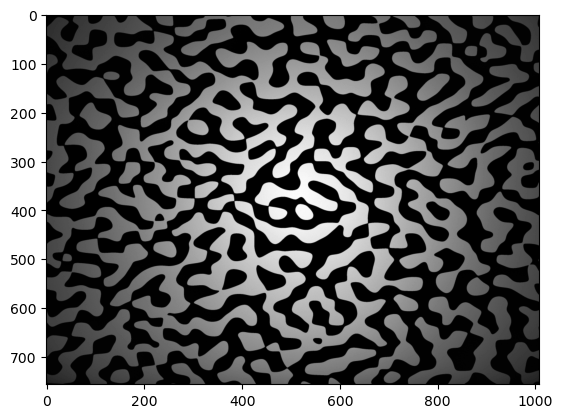

In [12]:
plt.imshow(down_sharp_train[0, 0,...,1], cmap='gray')

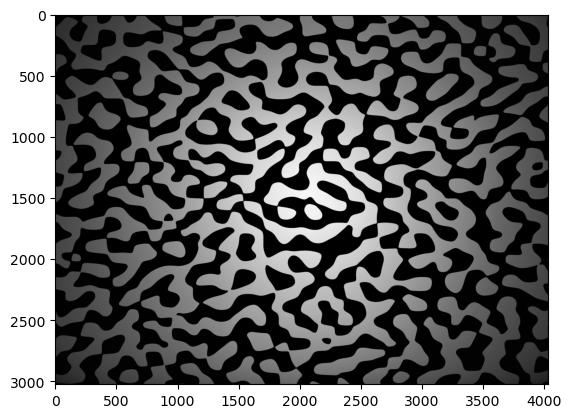

In [13]:
plt.imshow(sharp_np[0, 0,...,1], cmap='gray')